In [1]:
# ---------------------- Imports ---------------------- #
import pandas as pd

# ---------------------- File Paths ---------------------- #
actual_yields_path = r"C:\Users\azorb\PycharmProjects\Predicting the Yield Curve\Data Processing\Output\Dependent\Y_df.csv"
predicted_yields_path = r"C:\Users\azorb\PycharmProjects\Predicting the Yield Curve\Model Fit\LSTM\Output\LSTM Regression with Technical Indicators\Reconstructed Yields\reconstructed_yields_H1.csv"

# ---------------------- Read CSVs ---------------------- #
actual_df = pd.read_csv(actual_yields_path, index_col=0, parse_dates=True)
predicted_df = pd.read_csv(predicted_yields_path, index_col=0, parse_dates=True)

# ---------------------- Align on Dates ---------------------- #
# Ensure both DataFrames have datetime indices
actual_df.index = pd.to_datetime(actual_df.index)
predicted_df.index = pd.to_datetime(predicted_df.index)

# Inner join to keep only common timestamps
actual_aligned, predicted_aligned = actual_df.align(predicted_df, join='inner', axis=0)

# ---------------------- Print Info ---------------------- #
print(f"[INFO] Loaded actual yields with shape: {actual_df.shape}")
print(f"[INFO] Loaded predicted yields with shape: {predicted_df.shape}")
print(f"[INFO] After alignment: {actual_aligned.shape} common rows")

# ---------------------- Optional: Save Aligned Outputs ---------------------- #
# actual_aligned.to_csv("actual_yields_aligned.csv")
# predicted_aligned.to_csv("predicted_yields_aligned.csv")

[INFO] Loaded actual yields with shape: (5595, 6)
[INFO] Loaded predicted yields with shape: (756, 6)
[INFO] After alignment: (756, 6) common rows


C:\Users\azorb\AppData\Local\Temp\ipykernel_169992\661331172.py:48: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(14, 8), sharex=True)


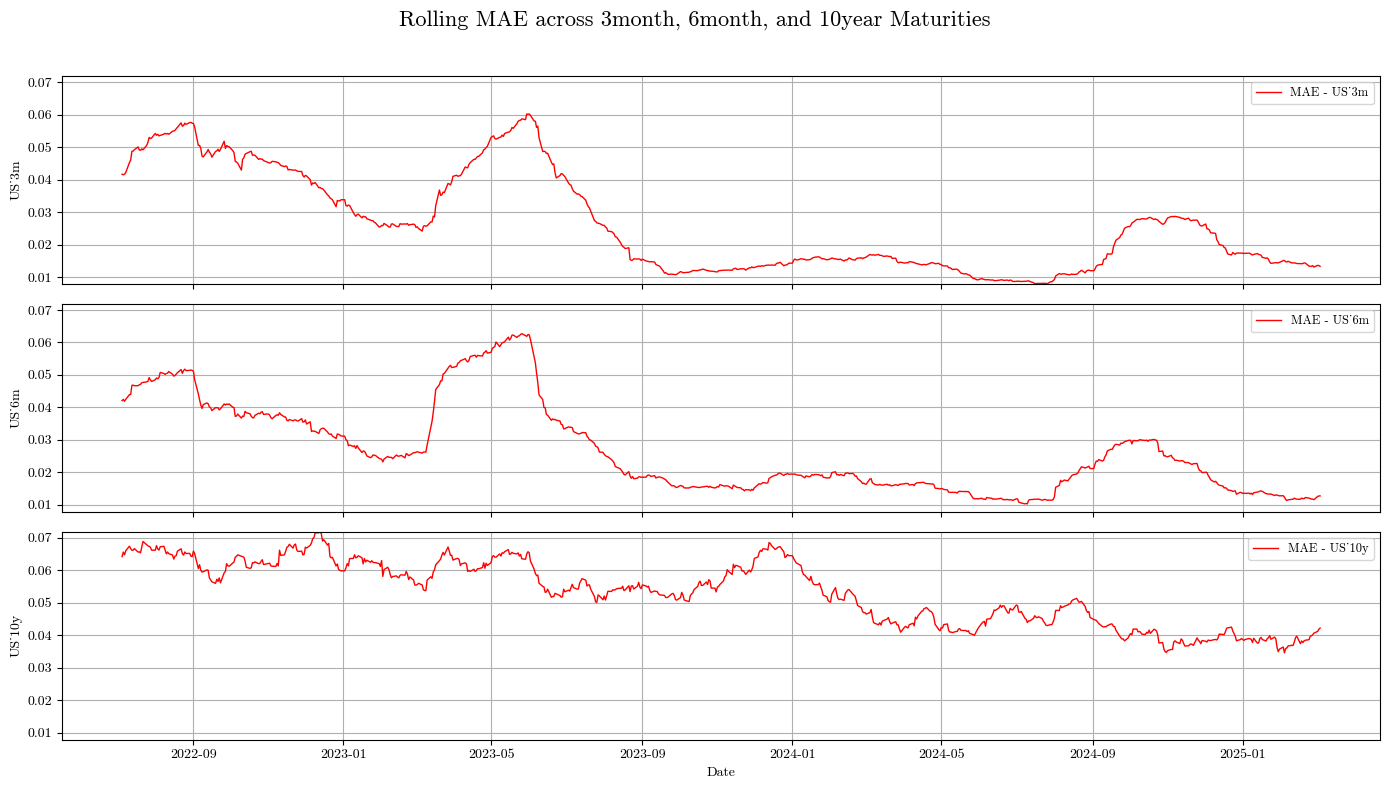

In [19]:
# ---------------------- Imports ---------------------- #
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------- File Paths ---------------------- #
actual_yields_path = r"C:\Users\azorb\PycharmProjects\Predicting the Yield Curve\Data Processing\Output\Dependent\Y_df.csv"
predicted_yields_path = r"C:\Users\azorb\PycharmProjects\Predicting the Yield Curve\Model Fit\LSTM\Output\LSTM Regression with Technical Indicators\Reconstructed Yields\reconstructed_yields_H1.csv"

# ---------------------- Maturity Mapping ---------------------- #
maturity_cols = {
    "m1": "US_3m",
    "m2": "US_6m",
    "m3": "US_1y",
    "m4": "US_3y",
    "m5": "US_5y",
    "m6": "US_10y"
}

selected_maturities = ["US_3m", "US_6m", "US_10y"]

# ---------------------- Parameters ---------------------- #
ROLLING_WINDOW = 60

# ---------------------- Load and Preprocess Data ---------------------- #
actual_df = pd.read_csv(actual_yields_path, index_col=0, parse_dates=True)
predicted_df = pd.read_csv(predicted_yields_path, index_col=0, parse_dates=True)

# Fix predicted columns
predicted_df.columns = [col.replace('_reconstructed', '') for col in predicted_df.columns]
predicted_df.rename(columns=maturity_cols, inplace=True)

# Align
actual_df.index = pd.to_datetime(actual_df.index)
predicted_df.index = pd.to_datetime(predicted_df.index)

common_cols = actual_df.columns.intersection(predicted_df.columns).intersection(selected_maturities)
actual_aligned = actual_df[common_cols].loc[actual_df.index.intersection(predicted_df.index)]
predicted_aligned = predicted_df[common_cols].loc[actual_aligned.index]

# ---------------------- Rolling MAE ---------------------- #
rolling_mae = (actual_aligned - predicted_aligned).abs().rolling(window=ROLLING_WINDOW).mean()

# ---------------------- Determine Shared Y-Limits ---------------------- #
ymin = rolling_mae.min().min()
ymax = rolling_mae.max().max()

# ---------------------- Plot MAE Subplots ---------------------- #
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(14, 8), sharex=True)

plt.rcParams['font.family'] = 'cmr10'  # Use Computer Modern Roman
plt.rcParams['mathtext.fontset'] = 'cm'  # Use Computer Modern for math text too

for i, col in enumerate(["US_3m", "US_6m", "US_10y"]):
    axs[i].plot(rolling_mae.index, rolling_mae[col], '-', color='red', label=f"MAE - {col}", linewidth=1)
    axs[i].set_ylabel(col)
    axs[i].set_ylim([ymin, ymax])
    axs[i].legend(loc="upper right", fontsize=9)
    axs[i].grid(True)

axs[-1].set_xlabel("Date")
fig.suptitle("Rolling MAE across 3month, 6month, and 10year Maturities", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [20]:
# ---------------------- Relative MAE (% of Yield Level) ---------------------- #
for col in ["US_3m", "US_10y"]:
    mae_mean = rolling_mae[col].mean()
    yield_mean = actual_aligned[col].mean()
    relative_mae_pct = (mae_mean / yield_mean) * 100
    print(f"[METRIC] {col}:")
    print(f"  Mean MAE       = {mae_mean:.4f}")
    print(f"  Mean Yield     = {yield_mean:.4f}")
    print(f"  Relative MAE   = {relative_mae_pct:.2f}%\n")

[METRIC] US_3m:
  Mean MAE       = 0.0263
  Mean Yield     = 4.5607
  Relative MAE   = 0.58%

[METRIC] US_10y:
  Mean MAE       = 0.0532
  Mean Yield     = 3.9196
  Relative MAE   = 1.36%



[DIRECTIONAL ACCURACY] US_3m: 35.76%


C:\Users\azorb\AppData\Local\Temp\ipykernel_169992\153142071.py:23: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(direction_correct.index, direction_correct, 'k|', markersize=10, label='Correct Direction')
C:\Users\azorb\AppData\Local\Temp\ipykernel_169992\153142071.py:29: UserWarning: Glyph 8211 (\N{EN DASH}) missing from font(s) cmr10.
  plt.tight_layout()
C:\Users\azorb\PycharmProjects\Predicting the Yield Curve\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8211 (\N{EN DASH}) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


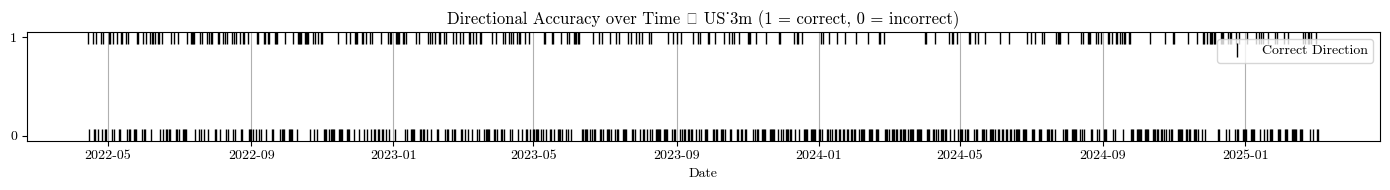

[DIRECTIONAL ACCURACY] US_10y: 46.36%


C:\Users\azorb\AppData\Local\Temp\ipykernel_169992\153142071.py:23: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(direction_correct.index, direction_correct, 'k|', markersize=10, label='Correct Direction')
C:\Users\azorb\AppData\Local\Temp\ipykernel_169992\153142071.py:29: UserWarning: Glyph 8211 (\N{EN DASH}) missing from font(s) cmr10.
  plt.tight_layout()
C:\Users\azorb\PycharmProjects\Predicting the Yield Curve\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8211 (\N{EN DASH}) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


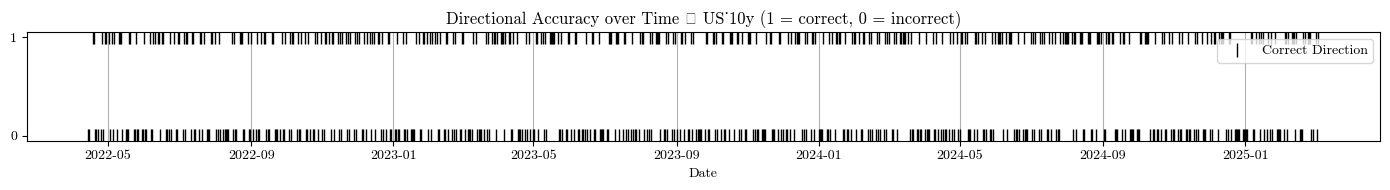

In [21]:
# ---------------------- Directional Accuracy ---------------------- #
accuracy_dict = {}

for col in ["US_3m", "US_10y"]:
    # Compute yield changes
    actual_diff = actual_aligned[col].diff().dropna()
    predicted_diff = predicted_aligned[col].diff().dropna()

    # Align after diff to ensure equal index
    actual_diff, predicted_diff = actual_diff.align(predicted_diff, join='inner')

    # Compare signs
    direction_correct = (actual_diff * predicted_diff > 0).astype(int)

    # Accuracy score
    accuracy = direction_correct.mean()
    accuracy_dict[col] = accuracy

    print(f"[DIRECTIONAL ACCURACY] {col}: {accuracy:.2%}")

    # Optional: plot directional accuracy as time series
    plt.figure(figsize=(14, 2))
    plt.plot(direction_correct.index, direction_correct, 'k|', markersize=10, label='Correct Direction')
    plt.title(f'Directional Accuracy over Time – {col} (1 = correct, 0 = incorrect)')
    plt.xlabel("Date")
    plt.yticks([0, 1])
    plt.grid(True, axis='x')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [63]:
threshold = 0.  # Set to 0 to include all non-zero predicted changes

for col in ["US_3m", "US_10y"]:
    # 1. Compute differences
    actual_diff = actual_aligned[col].diff().dropna()
    predicted_diff = predicted_aligned[col].diff().dropna()

    # 2. Suppress noise below threshold
    actual_diff = actual_diff.where(abs(actual_diff) > threshold, 0)
    predicted_diff = predicted_diff.where(abs(predicted_diff) > threshold, 0)

    # 3. Keep only days where the model predicted a change
    mask = predicted_diff != 0
    actual_eval = actual_diff[mask]
    predicted_eval = predicted_diff[mask]

    # 4. Handle case with no predictions
    if len(predicted_eval) == 0:
        print(f"[Directional Accuracy on Predictions] {col}: No predictions made above threshold.")
        continue

    # 5. Compute directional correctness
    direction_correct = (
        ((actual_eval * predicted_eval) > 0) |
        ((actual_eval == 0) & (predicted_eval == 0))  # Optional: treat flat-flat as correct
    ).astype(int)

    # 6. Compute and print accuracy
    accuracy = direction_correct.mean()
    print(f"[Directional Accuracy on Predictions] {col}: {accuracy:.2%}")

[Directional Accuracy on Predictions] US_3m: 3.03%
[Directional Accuracy on Predictions] US_10y: 9.90%


[Directional Accuracy on Predictions] US_10y: nan%
